Link to Google Colab where this notebook works

https://colab.research.google.com/drive/1bhkw0KOhdTtela83IMrdi6O-rcHSb4My?usp=sharing

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller



drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(directory):
    # List to store the DataFrames
    dataframes = []

    # Iterate over each CSV file in the directory
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            if 'datetime' not in df.columns:
                df = pd.read_csv(file_path, header=1)
            dataframes.append(df)

    # Concatenate all DataFrames into one
    df = pd.concat(dataframes)
    df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%dT%H:%M:%S")

    # Convert 'datetime' column to datetime typ

    return df

# Directory where the CSV files are located for Colchester and load data
directory_colchester = '/content/drive/MyDrive/Colab Notebooks/CE888/Colchester'
df_colchester = load_data(directory_colchester)
print("Colchester data info:")
print(df_colchester.info())

# Directory where the CSV files are located for Brighton and load data
directory_brighton = '/content/drive/MyDrive/Colab Notebooks/CE888/Brighton'
df_brighton = load_data(directory_brighton)
print("\nBrighton data info:")
print(df_brighton.info())

print('Lets check the range of dates in our data')
print(df_brighton['datetime'].min(), df_brighton['datetime'].max())


Colchester data info:
<class 'pandas.core.frame.DataFrame'>
Index: 188024 entries, 0 to 959
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          188024 non-null  datetime64[ns]
 1   temp              187606 non-null  float64       
 2   dew               187600 non-null  float64       
 3   humidity          187602 non-null  float64       
 4   precip            187437 non-null  float64       
 5   precipprob        187590 non-null  float64       
 6   preciptype        19448 non-null   object        
 7   snow              186478 non-null  float64       
 8   snowdepth         186429 non-null  float64       
 9   windspeed         187627 non-null  float64       
 10  winddir           187595 non-null  float64       
 11  sealevelpressure  180462 non-null  float64       
 12  cloudcover        184405 non-null  float64       
 13  solarradiation    94894 non-null   float64   

Let's work with the data in Brigthon for now.

In [ ]:
print(df_brighton['datetime'].min(), df_brighton['datetime'].max())

2010-01-01 00:00:00 2024-01-06 11:00:00


In [ ]:
# Sort the DataFrame by the 'datetime' column in descending order
df_brighton.sort_values(by='datetime', ascending=True, inplace=True)

# Now the index will be sorted from greatest to smallest


In [ ]:
# Set the 'datetime' column as the index
df_brighton.set_index('datetime', inplace=True)
df_brighton

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
datetime,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,"rain,snow",0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,NaN,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,NaN,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,NaN,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.0
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,NaN,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-06 07:00:00,5.1,3.5,89.07,NaN,0.0,NaN,NaN,NaN,9.6,327.0,1013.2,65.1,0.0,0.0,0.0
2024-01-06 08:00:00,5.0,3.5,90.24,NaN,0.0,NaN,NaN,NaN,8.9,320.0,1014.0,89.9,0.0,0.0,0.0
2024-01-06 09:00:00,4.9,3.9,92.89,NaN,0.0,NaN,NaN,NaN,9.6,321.0,1015.0,85.5,23.0,0.1,0.0


We have periodicity every year. In the plot we see 14 cycles (which correspond to our 14 years of data). Let's check:

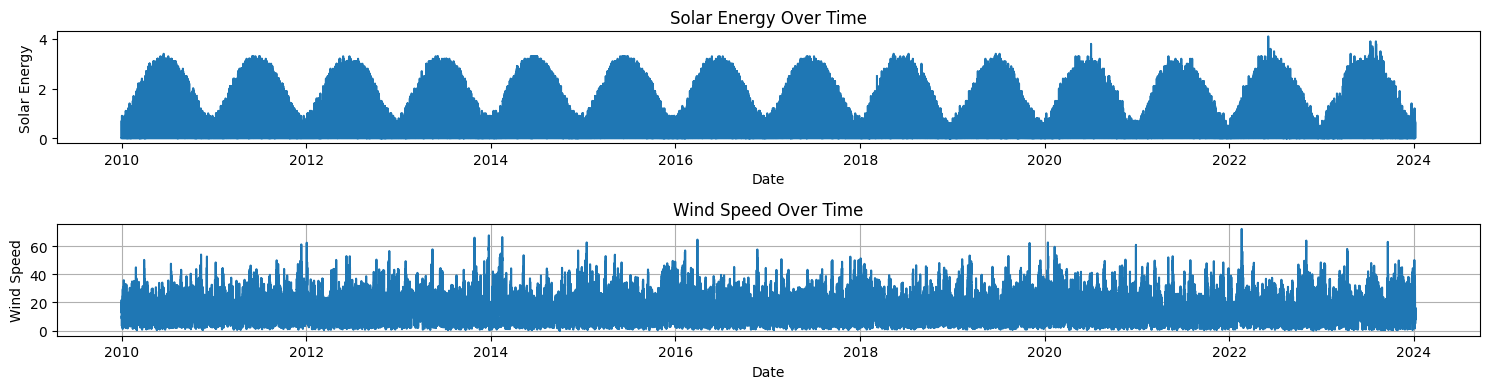

In [ ]:
fig, axes= plt.subplots(2,1, figsize=(15,4))

#first solar energy
axes[0].plot(df_brighton.index, df_brighton['solarenergy'])
axes[0].set_title('Solar Energy Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Solar Energy')

# Plot wind speed
axes[1].plot(df_brighton.index, df_brighton['windspeed'])
axes[1].set_title('Wind Speed Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Wind Speed')
axes[1].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


We can see a clearly periocity in solar energy.

In [ ]:
df_brighton.isna().sum()

temp                   254
dew                    276
humidity               269
precip                 279
precipprob             286
preciptype          111567
snow                 33034
snowdepth            33565
windspeed              261
winddir                277
sealevelpressure       525
cloudcover             288
solarradiation         330
solarenergy            364
uvindex                358
dtype: int64



*   261 null values for windspeed
*   364 null values for solarenergy




Lets see if there is any duplicates

In [ ]:
print(df_brighton.index.duplicated().any())
df_brighton[df_brighton.index.duplicated()].head(5)

True


,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
datetime,,,,,,,,,,,,,,,
2010-10-31 01:00:00,12.4,10.6,88.49,0.000,0.0,NaN,0.0,0.0,15.0,145.0,996.2,34.1,0.0,0.0,0.0
2011-10-30 01:00:00,14.4,12.5,88.08,0.000,0.0,NaN,0.0,0.0,25.3,227.0,1019.1,100.0,0.0,0.0,0.0
2012-10-28 01:00:00,2.6,0.9,88.68,0.112,100.0,rain,0.0,0.0,15.7,339.0,1020.5,6.2,0.0,0.0,0.0
2013-10-27 01:00:00,14.1,13.0,93.01,0.000,0.0,NaN,0.0,0.0,35.5,228.0,999.4,84.6,0.0,0.0,0.0
2014-10-26 01:00:00,13.4,8.7,73.15,0.000,0.0,NaN,NaN,NaN,13.4,241.0,1022.3,100.0,0.0,0.0,0.0


There is duplicates, so let's drop it

In [ ]:
# Let's create a new df so we can work from it without modify the original
df = df_brighton.copy()

# if we rmove duplicates based on all columns, there will be still duplicates so
#this doesn't works df = df.drop_duplicated()
df = df[~df.index.duplicated(keep='first')]
# Set 'datetime' as the index again


# Check if there are any duplicated indices
print(df.index.duplicated().any())



False


let's see how many data we have at the end without the duplicates

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122830 entries, 2010-01-01 00:00:00 to 2024-01-06 11:00:00
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   temp              122576 non-null  float64
 1   dew               122554 non-null  float64
 2   humidity          122561 non-null  float64
 3   precip            122551 non-null  float64
 4   precipprob        122544 non-null  float64
 5   preciptype        11274 non-null   object 
 6   snow              89800 non-null   float64
 7   snowdepth         89269 non-null   float64
 8   windspeed         122569 non-null  float64
 9   winddir           122553 non-null  float64
 10  sealevelpressure  122305 non-null  float64
 11  cloudcover        122542 non-null  float64
 12  solarradiation    122500 non-null  float64
 13  solarenergy       122466 non-null  float64
 14  uvindex           122472 non-null  float64
dtypes: float64(14), object(1)
memory u

we can observe that now we have 122,830 entries insted 122,844 that we had

In [ ]:
#Now we can reindex
df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='H'))
print(len(df))
#we have now 122844 values again

122844


In [ ]:
df.head(5)

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,"rain,snow",0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,NaN,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,NaN,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,NaN,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.0
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,NaN,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.0


As we saw, there is missing data and null data. We are going to filling this missing values

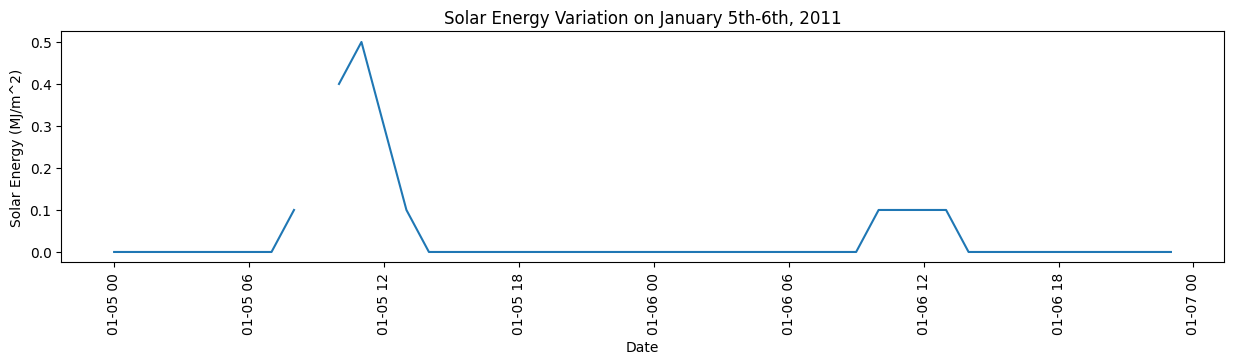

In [ ]:
# For solar energy
df_chunk = df.loc['2011-01-05':'2011-01-06']  # Since the date is an index, we can use it to filter our data

plt.figure(figsize=(15, 3))
plt.plot(df_chunk.index, df_chunk['solarenergy'])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Solar Energy (MJ/m^2)')
plt.title('Solar Energy Variation on January 5th-6th, 2011')


plt.show()


In [ ]:
# Create a boolean mask to identify rows with missing values in the 'solarenergy' column
nulls_solar = df['solarenergy'].isna()

# Shift the values in all columns by 8760 periods (one year)
# to fill the missing values with values from the same period one year ago
df.loc[nulls_solar] = df.shift(8760)  # 8760 periods in a year


As I'm filling with the previous year, I still have nulls from 2010 that don't have any previous year since it's our first year.

Let's fill 2010 with the year 2011


In [ ]:
# Create a boolean mask to identify rows with missing values in the 'solarenergy' column and belonging to the year 2010
nulls_2010 = df['solarenergy'].isna() & (df.index.year == 2010)

# Shift the values in the 'solarenergy' column by 1 period backward to fill the missing values specifically for the year 2010
df.loc[nulls_2010, 'solarenergy'] = df['solarenergy'].shift(-1)


In [ ]:
df[df['solarenergy'].isna()]

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
2011-08-12 01:00:00,14.3,11.5,83.14,0.0,0.0,NaN,0.0,0.0,11.0,337.0,1014.7,28.3,0.0,NaN,0.0


In [ ]:
 #there i ps still a null in 2011-08-12 01:00:00 so, let's repet
nulls = df['solarenergy'].isna()
df.loc[nulls, 'solarenergy'] = df['solarenergy'].shift(8760) #8760 periodos

Now, let's do it for solar energy

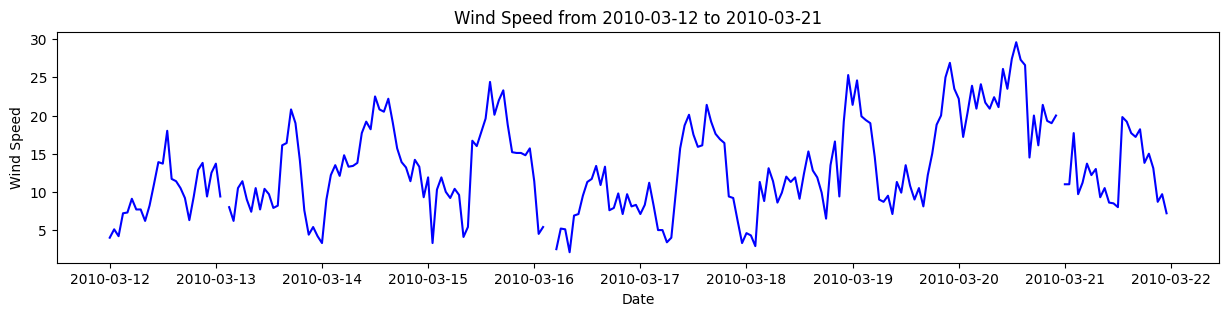

In [ ]:
# Select the chunk of data
df_chunk_wind = df.loc['2010-03-12':'2010-03-21']

# Plot the wind speed data
plt.figure(figsize=(15, 3))
plt.plot(df_chunk_wind.index, df_chunk_wind['windspeed'], color='blue', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.title('Wind Speed from 2010-03-12 to 2010-03-21')

# Display the plot
plt.show()


In [ ]:
# Find null values in the 'windspeed' column
nulls = df['windspeed'].isna()

df.loc[nulls, 'windspeed'] = df['windspeed'].shift(8760) # Shift the values of 'windspeed' column by 8760 periods (assuming hourly data)

there are still duplicates, let's resolve the 2010 duplicates

In [ ]:
# Create a boolean mask to identify rows with missing values in the 'solarenergy' column and belonging to the year 2010
nulls_2010 = df['windspeed'].isna() & (df.index.year == 2010)

df.loc[nulls_2010, 'windspeed'] = df['windspeed'].shift(-1) # Shift the values in the 'solarenergy' column by 1 period backward to fill the missing values specifically for the year 2010

Thera are two dates missing data, let's give it two years

In [ ]:
 #there i ps still a null in 2011-08-12 01:00:00 so, let's repet
nulls = df['windspeed'].isna()
df.loc[nulls, 'windspeed'] = df['solarenergy'].shift(8760) #8760 periodos

#and again for 2010
nulls_2010 = df['windspeed'].isna() & (df.index.year == 2010) # Create a boolean mask to identify rows with missing values in the 'solarenergy' column and belonging to the year 2010
df.loc[nulls_2010, 'windspeed'] = df['windspeed'].shift(-1) # Shift the values in the 'solarenergy' column by 1 period backward to fill the missing values specifically for the year 2010

In [ ]:
df[df['windspeed'].isna()]

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex


#### Let's save de df

In [ ]:
directory_brighton = '/content/drive/MyDrive/Colab Notebooks/CE888/df_brighton.csv'

df.to_csv(directory_brighton, index_label='datetime')

Now that we don't have any missing data, let's examine the behavior of our dataset.

---


I'll perform a decomposition of the wind speed data to uncover its underlying components, including trend, seasonality, and residual. This may help us identify any patterns and trends within the dataset.

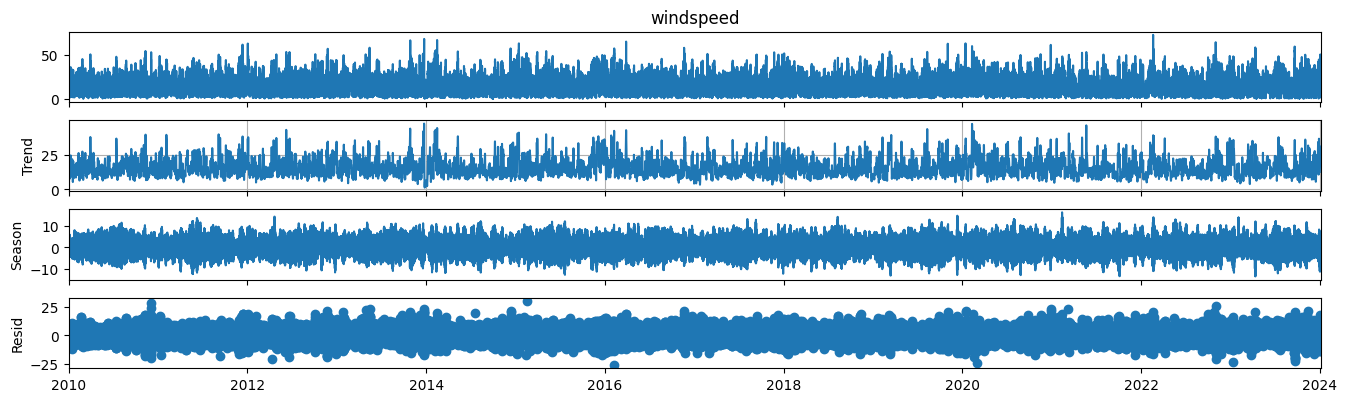

In [ ]:
# Try decomposition on the resampled dataset, using only the full years
# we can see only one year to see what is happening
decomposition = STL(df[ 'windspeed']).fit()  # Perform decomposition on the windspeed data
fig = decomposition.plot()  # Plot the decomposition
fig.set_size_inches(15,4)  # Set the size of the figure
fig.axes[1].grid()  # Add a grid to the second axis of the plot to aid visualization of any trends

Now, for solarenergy

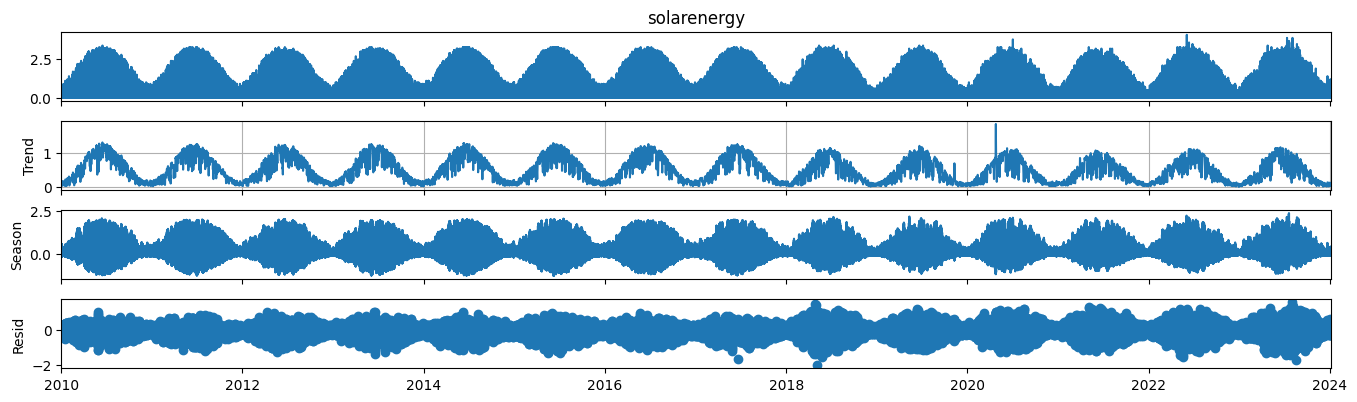

In [ ]:
# Try decomposition on the resampled dataset
decomposition = STL(df['solarenergy']).fit()  # Fit the STL decomposition model to the 'solarenergy' data
fig = decomposition.plot()  # Plot the decomposition
fig.set_size_inches(15,4)  # Set the size of the figure
fig.axes[1].grid()  # Add a grid to the second axis of the plot to aid visualization of any trends

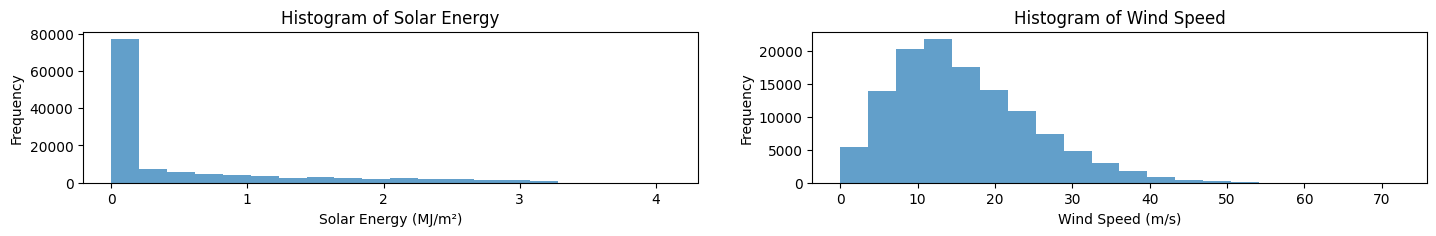

In [ ]:
# Subplots for histograms of solar energy and wind speed so we can see the data.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

# Plot histogram for solar energy
axes[0].hist(df['solarenergy'], bins=20,  alpha=0.7)  # Plot histogram of solar energy with 20 bins and 0.7 transparency
axes[0].set_title('Histogram of Solar Energy')  # Set title for the first subplot
axes[0].set_xlabel('Solar Energy (MJ/m²)')  # Set x-axis label for the first subplot
axes[0].set_ylabel('Frequency')  # Set y-axis label for the first subplot

# Plot histogram for wind speed
axes[1].hist(df['windspeed'], bins=20, alpha=0.7)  # Plot histogram of wind speed with 20 bins and 0.7 transparency
axes[1].set_title('Histogram of Wind Speed')  # Set title for the second subplot
axes[1].set_xlabel('Wind Speed (m/s)')  # Set x-axis label for the second subplot
axes[1].set_ylabel('Frequency')  # Set y-axis label for the second subplot

# Adjust layout and spacing between subplots
plt.tight_layout(pad=3.0)  # Adjust layout of subplots to avoid overlapping and provide spacing

# Show the plot
plt.show()


Let's see the distribution of data throughout the day for solar energy and wind speed.

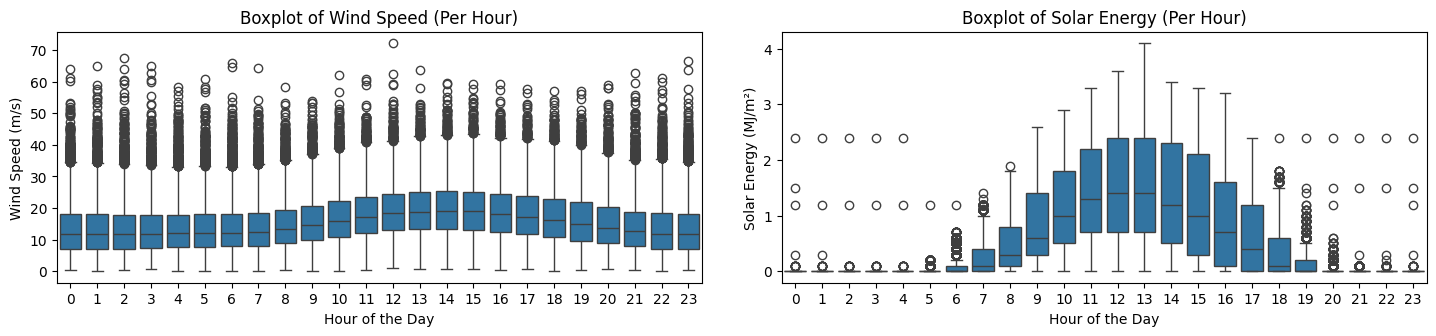

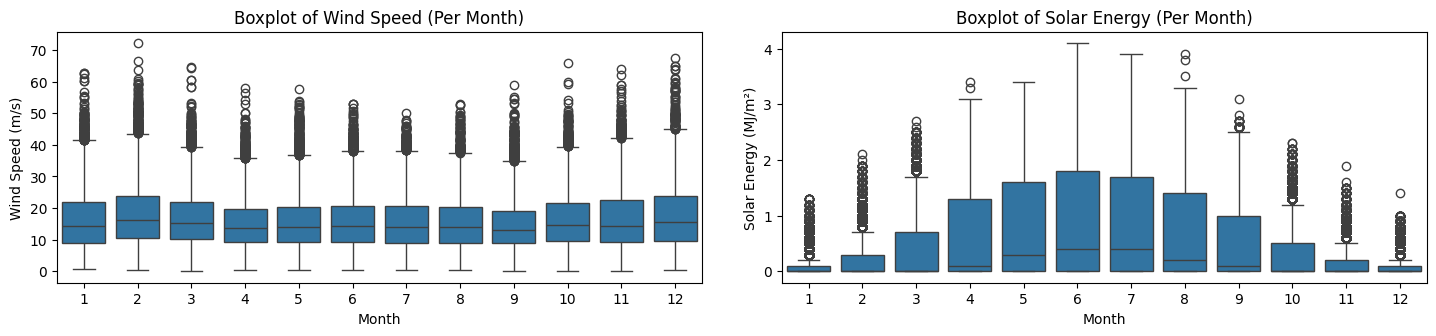

In [ ]:
# Create temporal columns for month, year, week of the year, and hour
df['month'] = df.index.month
df['year'] = df.index.year
df['week_of_year'] = df.index.isocalendar().week
df['hour'] = df.index.hour

# Create a figure and axes with two subplots for hourly boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Boxplot for wind speed per hour
sns.boxplot(x='hour', y='windspeed', data=df, ax=axes[0])  # Plot boxplot for wind speed per hour
axes[0].set_title('Boxplot of Wind Speed (Per Hour)')  # Set title for the first subplot
axes[0].set_xlabel('Hour of the Day')  # Set x-axis label for the first subplot
axes[0].set_ylabel('Wind Speed (m/s)')  # Set y-axis label for the first subplot

# Boxplot for solar energy per hour
sns.boxplot(x='hour', y='solarenergy', data=df, ax=axes[1])  # Plot boxplot for solar energy per hour
axes[1].set_title('Boxplot of Solar Energy (Per Hour)')  # Set title for the second subplot
axes[1].set_xlabel('Hour of the Day')  # Set x-axis label for the second subplot
axes[1].set_ylabel('Solar Energy (MJ/m²)')  # Set y-axis label for the second subplot

# Adjust layout and spacing between subplots
plt.tight_layout(pad=3.0)  # Adjust layout of subplots to avoid overlapping and provide spacing

# Show the plot
plt.show()

# Create a figure and axes with two subplots for monthly boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Boxplot for wind speed per month
sns.boxplot(x='month', y='windspeed', data=df, ax=axes[0])  # Plot boxplot for wind speed per month
axes[0].set_title('Boxplot of Wind Speed (Per Month)')  # Set title for the first subplot
axes[0].set_xlabel('Month')  # Set x-axis label for the first subplot
axes[0].set_ylabel('Wind Speed (m/s)')  # Set y-axis label for the first subplot

# Boxplot for solar energy per month
sns.boxplot(x='month', y='solarenergy', data=df, ax=axes[1])  # Plot boxplot for solar energy per month
axes[1].set_title('Boxplot of Solar Energy (Per Month)')  # Set title for the second subplot
axes[1].set_xlabel('Month')  # Set x-axis label for the second subplot
axes[1].set_ylabel('Solar Energy (MJ/m²)')  # Set y-axis label for the second subplot

# Adjust layout and spacing between subplots
plt.tight_layout(pad=3.0)  # Adjust layout of subplots to avoid overlapping and provide spacing

# Show the plot
plt.show()


We can observe varios atypical values let's do a close up to evaluate if there is something that I did or the data was like that.

In [ ]:
df[(df.index.hour == 0) & (df['solarenergy'] != 0)]

#Those are the values after to do the cleaning data

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,month,year,week_of_year,hour
2018-11-27,3.3,2.7,95.87,0.000,0.0,NaN,0.0,0.0,10.8,330.0,1017.2,78.0,93.0,0.3,0.0,11,2018,48,0
2019-11-10,5.5,5.0,96.19,0.807,100.0,rain,0.0,0.0,5.1,16.0,1002.2,84.4,338.0,1.2,0.0,11,2019,45,0
2020-04-25,7.4,4.4,81.17,0.000,0.0,NaN,NaN,NaN,5.4,33.0,1015.4,17.8,679.0,2.4,0.0,4,2020,17,0
2020-06-09,11.4,7.0,74.83,0.000,0.0,NaN,NaN,NaN,5.2,53.0,1020.9,94.3,429.0,1.5,0.0,6,2020,24,0
2020-12-09,-0.2,-0.3,99.80,0.043,100.0,"rain,snow",NaN,NaN,3.9,228.0,1006.7,81.5,18.0,0.1,0.0,12,2020,50,0
2020-12-25,3.4,0.4,80.89,0.000,0.0,NaN,0.0,0.0,26.6,341.0,1028.4,56.2,21.0,0.1,0.0,12,2020,52,0
2020-12-26,-0.3,-1.7,90.49,0.000,0.0,NaN,0.0,0.0,11.6,249.0,1029.7,71.6,21.0,0.1,0.0,12,2020,52,0
2021-01-04,3.2,1.8,90.85,0.171,100.0,rain,0.0,0.0,17.2,18.0,1018.0,82.9,37.0,0.1,0.0,1,2021,1,0
2021-01-05,2.1,0.1,86.84,0.153,100.0,rain,0.0,0.0,22.4,14.0,1018.7,50.1,37.0,0.1,0.0,1,2021,1,0
2022-12-20,11.9,10.9,93.52,0.039,100.0,rain,0.0,0.0,34.6,193.0,1007.2,95.2,18.0,0.1,0.0,12,2022,51,0


In [ ]:
df_brighton[(df_brighton.index.hour == 0) & (df_brighton['solarenergy'] != 0)]

# This was the data before, so we can observe a difference, but only in the NaN data.
#Our filling didn't affect the data, and despite the fact that the data is incorrect, we can't delete it because we're dealing with a time series.


,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex
datetime,,,,,,,,,,,,,,,
2014-11-17,8.7,8.0,95.70,0.842,100.0,rain,NaN,NaN,9.9,352.0,999.7,94.0,0.0,NaN,0.0
2015-09-12,17.4,12.0,70.86,0.000,0.0,NaN,NaN,NaN,20.5,96.0,1009.8,90.9,0.0,NaN,0.0
2015-10-03,8.0,7.0,93.22,0.000,0.0,NaN,NaN,NaN,10.8,353.0,1019.5,32.1,0.0,NaN,0.0
2017-09-14,9.6,6.5,81.25,0.000,0.0,NaN,0.0,0.0,10.5,275.0,1002.5,52.3,0.0,NaN,0.0
2018-01-07,4.0,0.6,78.87,0.018,100.0,rain,0.0,0.0,25.5,24.0,1019.0,73.1,0.0,NaN,0.0
2018-02-09,6.4,3.4,81.41,0.000,0.0,NaN,0.0,0.0,28.3,209.0,1012.3,73.4,0.0,NaN,0.0
2018-11-27,3.3,2.7,95.87,0.000,0.0,NaN,0.0,0.0,10.8,330.0,1017.2,78.0,93.0,0.3,0.0
2018-12-23,5.4,4.9,96.46,0.000,0.0,NaN,0.0,0.0,2.6,229.0,1022.1,81.3,0.0,NaN,0.0
2019-09-17,15.9,14.1,89.31,0.000,0.0,NaN,0.0,0.0,5.0,17.0,1023.0,69.8,0.0,NaN,0.0


We can see that we are working with seasional data.

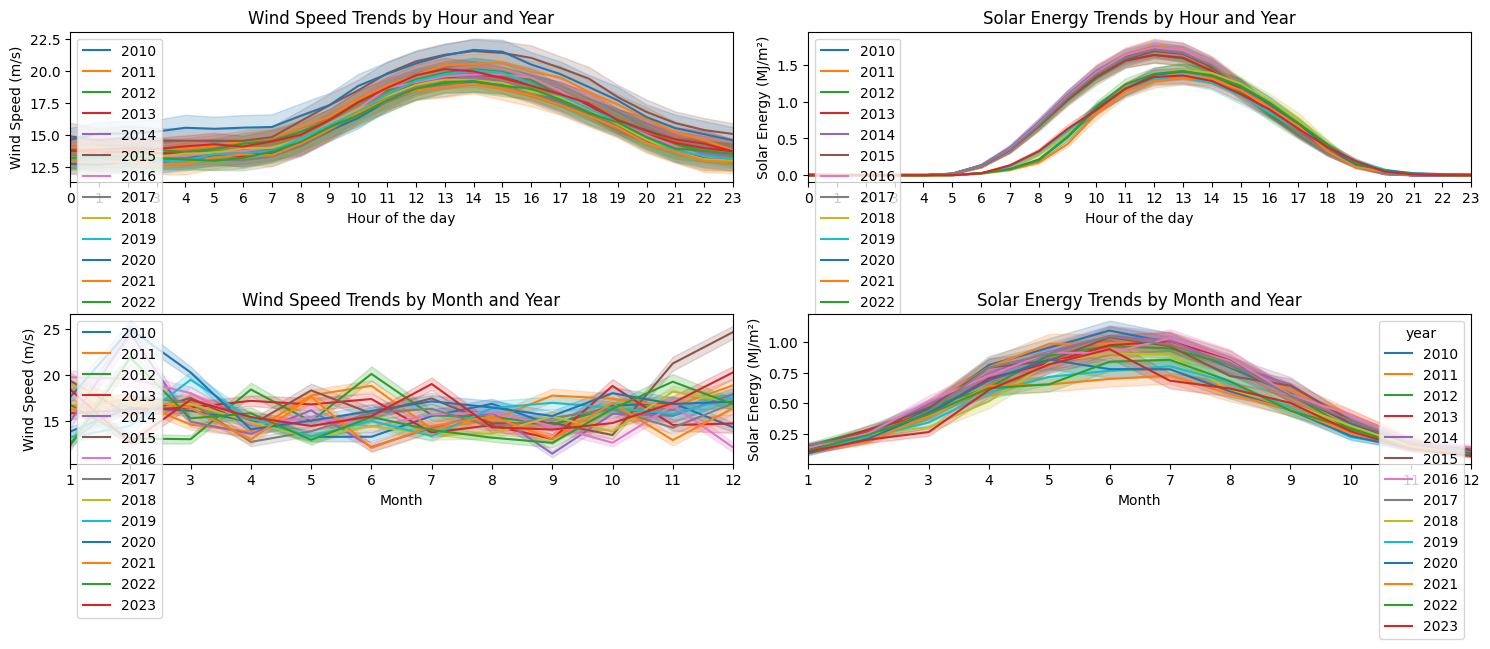

In [ ]:
# Filter the DataFrame to exclude data from 2024
df_filtered = df[df['year'] != 2024]

# Create a figure with four subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

# Plot wind speed trends by hour and year
sns.lineplot(x='hour', y='windspeed', data=df_filtered, hue='year', palette='tab10', ax=axes[0, 0])
axes[0, 0].set_xticks(np.arange(0, 24))
axes[0, 0].set_xlim(0, 23)
axes[0, 0].set_xlabel('Hour of the day')
axes[0, 0].set_ylabel('Wind Speed (m/s)')
axes[0, 0].set_title('Wind Speed Trends by Hour and Year')
axes[0, 0].legend(loc='upper left')  # Adjust the location of the legend

# Plot solar energy trends by hour and year
sns.lineplot(x='hour', y='solarenergy', data=df_filtered, hue='year', palette='tab10', ax=axes[0, 1])
axes[0, 1].set_xticks(np.arange(0, 24))
axes[0, 1].set_xlim(0, 23)
axes[0, 1].set_xlabel('Hour of the day')
axes[0, 1].set_ylabel('Solar Energy (MJ/m²)')
axes[0, 1].set_title('Solar Energy Trends by Hour and Year')
axes[0, 1].legend(loc='upper left')  # Adjust the location of the legend

# Plot wind speed trends by month and year
sns.lineplot(x='month', y='windspeed', data=df_filtered, hue='year', palette='tab10', ax=axes[1, 0])
axes[1, 0].set_xticks(np.arange(1, 13))
axes[1, 0].set_xlim(1, 12)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Wind Speed (m/s)')
axes[1, 0].set_title('Wind Speed Trends by Month and Year')
axes[1, 0].legend(loc='upper left')  # Adjust the location of the legend

# Plot solar energy trends by month and year
sns.lineplot(x='month', y='solarenergy', data=df_filtered, hue='year', palette='tab10', ax=axes[1, 1])
axes[1, 1].set_xticks(np.arange(1, 13))
axes[1, 1].set_xlim(1, 12)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Solar Energy (MJ/m²)')
axes[1, 1].set_title('Solar Energy Trends by Month and Year')
#axes[1, 1].legend(loc='upper left')  # Adjust the location of the legend

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


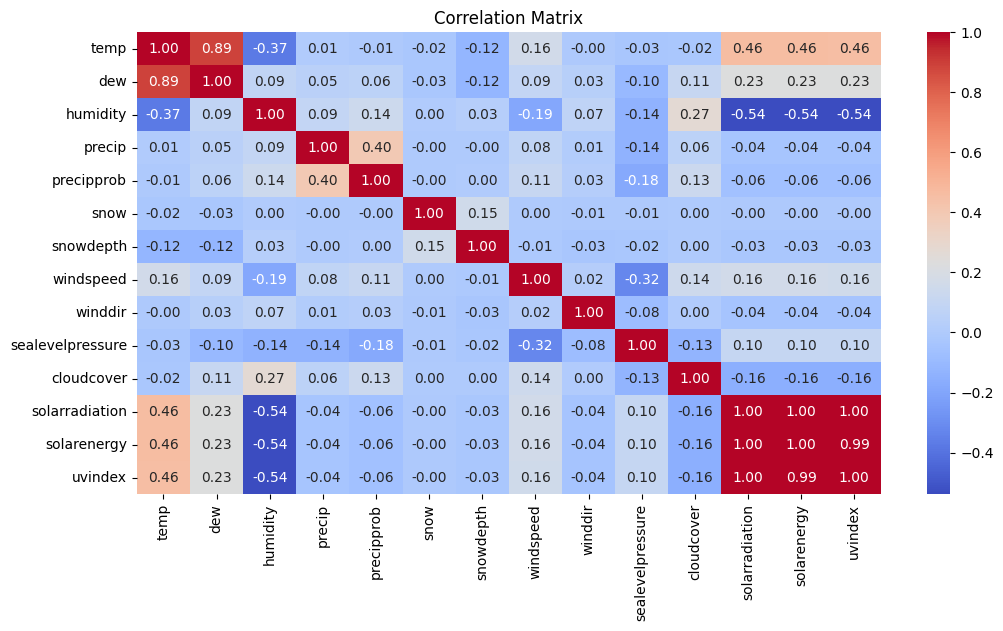

In [ ]:

# Select only the numeric columns to calculate the correlation
numeric_columns = df.select_dtypes(include=['float64']).columns

# Calculate the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Visualize the correlation matrix using a heatmap
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



There is not a huge correlation between the variabes, but how about how tightly past data, predicts future data. Let's see their autocorrelation






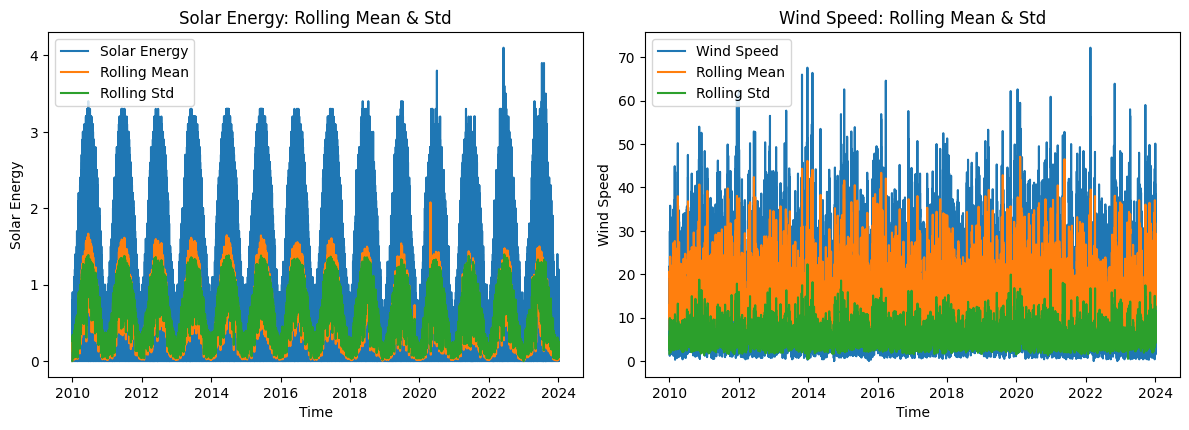

In [ ]:
# Calculate rolling mean and rolling standard deviation for solar energy
rolling_mean_solar = df['solarenergy'].rolling(window=30, min_periods=1).mean()
rolling_std_solar = df['solarenergy'].rolling(window=30, min_periods=1).std()

# Calculate rolling mean and rolling standard deviation for wind speed
rolling_mean_wind = df['windspeed'].rolling(window=30, min_periods=1).mean()
rolling_std_wind = df['windspeed'].rolling(window=30, min_periods=1).std()

# Plot the rolling statistics
plt.figure(figsize=(12, 8))

# Subplot 1: Solar Energy - Original vs. Rolling Mean vs. Rolling Std
plt.subplot(2, 2, 1)
plt.plot(df['solarenergy'], label='Solar Energy')  # Plot original solar energy data
plt.plot(rolling_mean_solar, label='Rolling Mean')  # Plot rolling mean
plt.plot(rolling_std_solar, label='Rolling Std')  # Plot rolling standard deviation
plt.title('Solar Energy: Rolling Mean & Std')  # Set title
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Solar Energy')  # Label y-axis
plt.legend()  # Show legend

# Subplot 2: Wind Speed - Original vs. Rolling Mean vs. Rolling Std
plt.subplot(2, 2, 2)
plt.plot(df['windspeed'], label='Wind Speed')  # Plot original wind speed data
plt.plot(rolling_mean_wind, label='Rolling Mean')  # Plot rolling mean
plt.plot(rolling_std_wind, label='Rolling Std')  # Plot rolling standard deviation
plt.title('Wind Speed: Rolling Mean & Std')  # Set title
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Wind Speed')  # Label y-axis
plt.legend()  # Show legend

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot


Autocorrelation Analysis:

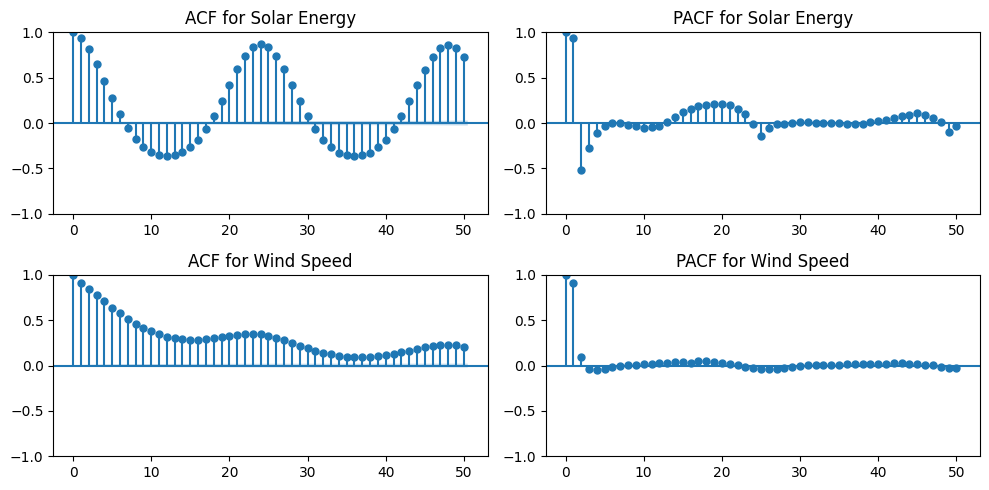

In [ ]:
# Calculate and graph ACF and PACF for 'solarenergy' and 'windspeed'
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

plot_acf(df['solarenergy'], lags=50, ax=ax[0, 0]) # ACF for 'solarenergy'
ax[0, 0].set_title('ACF for Solar Energy')  # Set title for ACF plot

plot_pacf(df['solarenergy'], lags=50, ax=ax[0, 1]) # PACF for 'solarenergy'
ax[0, 1].set_title('PACF for Solar Energy')  # Set title for PACF plot

plot_acf(df['windspeed'], lags=50, ax=ax[1, 0]) # ACF for 'windspeed'
ax[1, 0].set_title('ACF for Wind Speed')  # Set title for ACF plot

plot_pacf(df['windspeed'], lags=50, ax=ax[1, 1]) # PACF for 'windspeed'
ax[1, 1].set_title('PACF for Wind Speed')  # Set title for PACF plot

plt.tight_layout()
plt.show()


I will display the numbers to see exactly what I was getting because I couldn't see the exact data from the plot.

### ACF for Solar Energy:

We observe a strong correlation from lag 1 to 8, and then from lag 19 to lag 30, with the highest correlations occurring at lags 1, 2, and 3, with values of 1, 0.93, and 0.81, respectively. However, these correlations indicate values two and three hours before, which may not be as useful for our forecasting. We aim for at least a 24-hour. Beyond 24 hours, we see the correlation decrease to 0.73, and after 48 hours, it is 0.72. Interestingly, after 26 hours, the autocorrelation increases to 0.87, and after 50 hours, it remains high at 0.86.


### PACF for Solar Energy:

The partial autocorrelation values for solar energy also exhibit a strong correlation at lags 1 and 2, followed by a decrease. The partial autocorrelation at lag 1 is high (0.9377), suggesting that solar energy generation at a given time is strongly correlated with the immediately preceding value. As we move through the lags, the partial autocorrelation becomes insignificant after lag 3, indicating that the direct influence of previous periods gradually diminishes.


### ACF for wind speed:

We observe a strong correlation from lag 1 to 8 and then from lag 19 to 30, with the highest correlations at lags 1, 2, and 3, having values of 1, 0.91, and 0.84, respectively. The correlation remains relatively high up to lag 13, after which it gradually decreases. Notably, after 24 hours (lag 25), the autocorrelation increases to 0.34, and then decreases again.

### PACF for wind speed:

The partial autocorrelation for wind speed shows significant values up to lag 13, with a noticeable decrease afterward. The highest partial autocorrelation occurs at lag 1 (1.0), indicating a strong correlation with the immediate preceding value. The partial autocorrelation gradually decreases, becoming insignificant after lag 3.

We'll split the data so we are going to prepare to predict the data.

    Training set: From January 1, 2010, to December 31, 2021
    Validation set: From January 1, 2022, to December 31, 2022
    Test set: From January 1, 2023, to the end of the data (2024-01-06 11:00:00)

In [ ]:
# Filter the data based on date ranges
train_set = df.loc['2010-01-01':'2020-12-31']
val_set = df.loc['2021-01-01':'2022-12-31']
test_set = df.loc['2023-01-01':]

# Check the lengths of each set
print("Training set length:", len(train_set))
print("Validation set length:", len(val_set))
print("Test set length:", len(test_set))


Training set length: 96432
Validation set length: 17520
Test set length: 8892


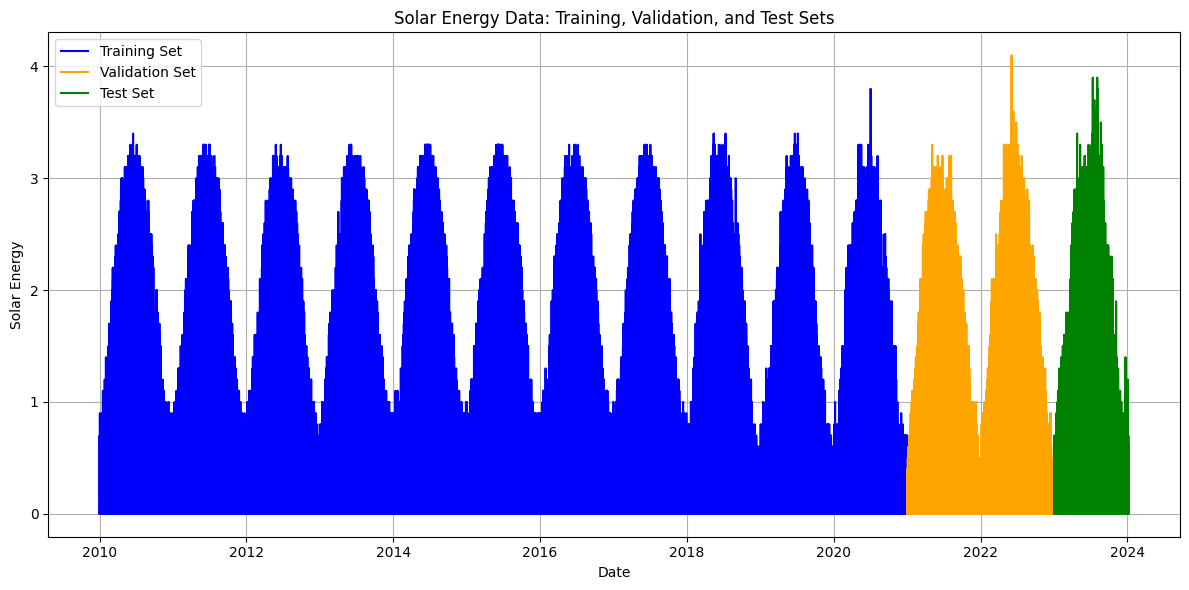

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['solarenergy'], label='Training Set', color='blue')
plt.plot(val_set.index, val_set['solarenergy'], label='Validation Set', color='orange')
plt.plot(test_set.index, test_set['solarenergy'], label='Test Set', color='green')

plt.title('Solar Energy Data: Training, Validation, and Test Sets')
plt.xlabel('Date')
plt.ylabel('Solar Energy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NOw, let's do it dot Wind speed

Training set length (wind speed): 96432
Validation set length (wind speed): 17520
Test set length (wind speed): 8892


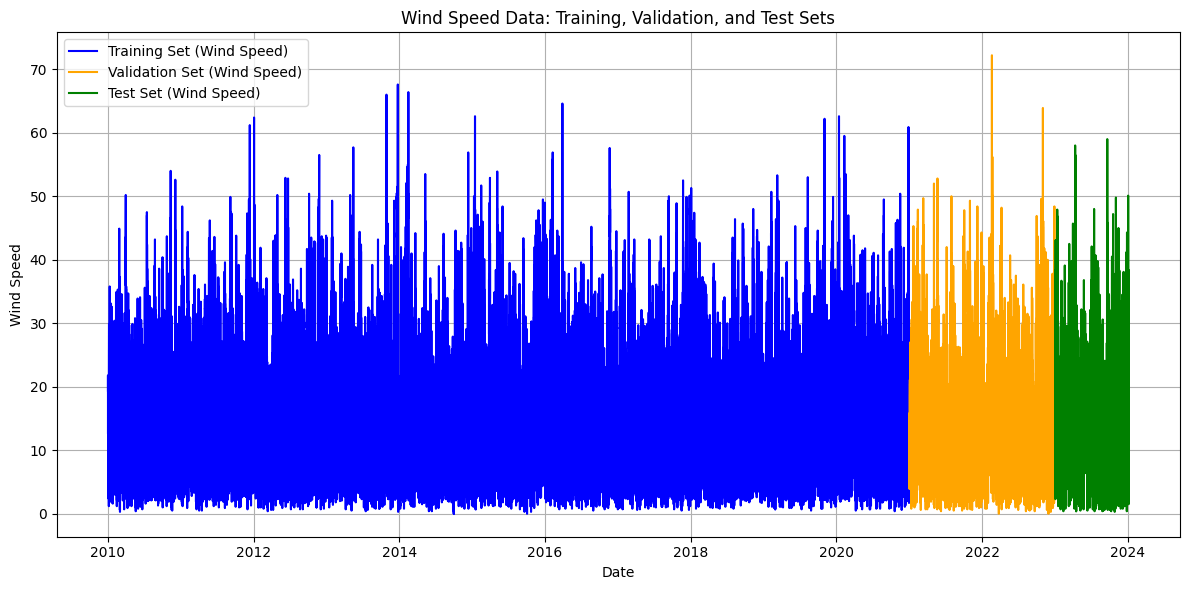

In [ ]:
# Filter the data based on date ranges for wind speed
train_set_wind = df.loc['2010-01-01':'2020-12-31']
val_set_wind = df.loc['2021-01-01':'2022-12-31']
test_set_wind = df.loc['2023-01-01':]

# Check the lengths of each set for wind speed
print("Training set length (wind speed):", len(train_set_wind))
print("Validation set length (wind speed):", len(val_set_wind))
print("Test set length (wind speed):", len(test_set_wind))

# Plotting for wind speed
plt.figure(figsize=(12, 6))
plt.plot(train_set_wind.index, train_set_wind['windspeed'], label='Training Set (Wind Speed)', color='blue')
plt.plot(val_set_wind.index, val_set_wind['windspeed'], label='Validation Set (Wind Speed)', color='orange')
plt.plot(test_set_wind.index, test_set_wind['windspeed'], label='Test Set (Wind Speed)', color='green')

plt.title('Wind Speed Data: Training, Validation, and Test Sets')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The data is ready to use.

Following the steps to identify a random walk, a moving average process MA(q), an autoregressive process AR(p), and an autoregressive moving average process ARMA(p, q):


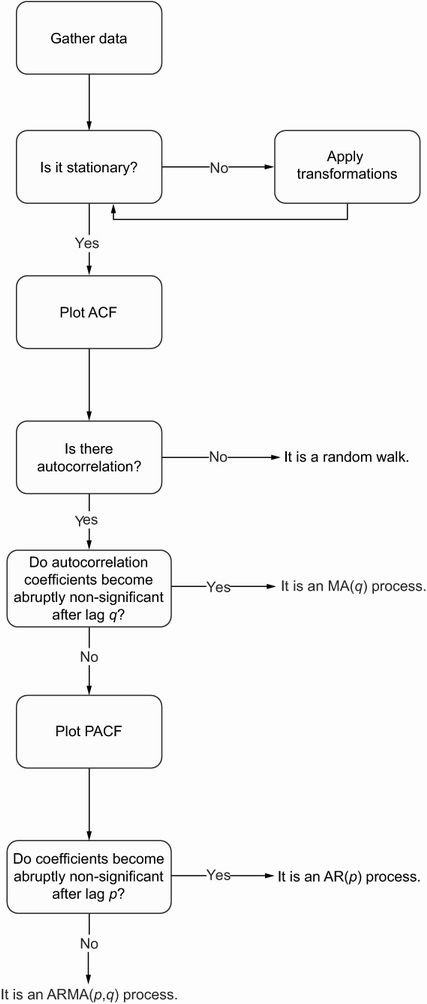

In [ ]:
df = df.fillna(0)

Let's see first solar energy:

As we have seen, if it is stationary.

In [ ]:

# Perform Augmented Dickey-Fuller test on the 'solarenergy' series
ADF_result = adfuller(df['solarenergy'])

# Print ADF Statistic and p-value
print(f'ADF Statistic: {ADF_result[0]}')  # ADF Statistic provides a measure of how strongly time series is stationary
print(f'p-value: {ADF_result[1]}')  # The p-value indicates the significance of the ADF Statistic result


ADF Statistic: -10.80524600861672
p-value: 1.9708916465479546e-19


El p-value es 1.9708916465479546e-19, que es un valor extremadamente pequeño. El p-value es la probabilidad de obtener un resultado tan extremo como el observado si la hipótesis nula fuera verdadera. En este caso, el valor del p-value es mucho más pequeño que cualquier nivel de significancia comúnmente utilizado (como 0.05 o 0.01), lo que indica una fuerte evidencia en contra de la hipótesis nula.
Conclusión:

Dado que el ADF Statistic es menor que los valores críticos y el p-value es muy pequeño, podemos rechazar la hipótesis nula de que los datos tienen una raíz unitaria. En otras palabras, los datos son estacionarios.

Let's look at the ACF:

<Figure size 1000x400 with 0 Axes>

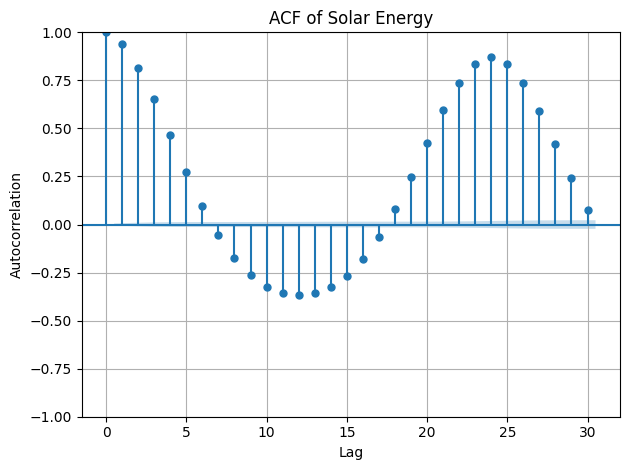

In [ ]:
plt.figure(figsize=(10, 4))
plot_acf(df['solarenergy'], lags=30, alpha=0.05)  # Specify the number of lags and significance level
plt.title('ACF of Solar Energy')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()



The autocorrelation coefficients for Solar Energy do not become abruptly non-significant after any lag, supporting the notion that we are likely dealing with an autoregressive (AR) process. This information is crucial for selecting an appropriate forecasting model, particularly for our goal of predicting 24 hours into the future.

Let's plot PACF

<Figure size 1000x600 with 0 Axes>

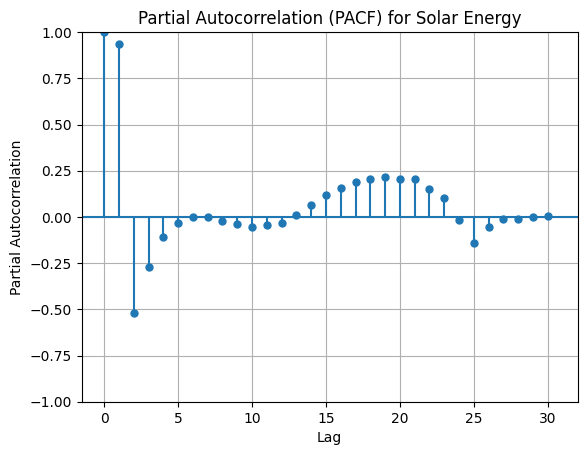

In [ ]:
plt.figure(figsize=(10, 6))
plot_pacf(df['solarenergy'], lags=30, alpha=0.05, method='ols')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation (PACF) for Solar Energy')
plt.grid(True)
plt.show()



When looking at the Partial Autocorrelation Function (PACF) for Solar Energy, we see that the coefficients become non-significant after the second lag

This information can help us determine the order of the Auto Regressive (AR) component of an ARIMA model for solar energy. Since the PACF abruptly becomes non-significant after lag 2, we might consider an ARIMA model with an AR component of order 2 (p=2). This implies that the current observation may be influenced by the two previous observations.  

Which can also be denoted as AR(2).

In [ ]:
df.drop(columns=['preciptype'], inplace=True)

Let's split the data as follows:

    Training set: From January 1, 2010, to December 31, 2021
    Validation set: From January 1, 2022, to December 31, 2022
    Test set: From January 1, 2023, to the end of the data (January 6, 2024)

In [ ]:
# Filter the data based on date ranges
train_set = df.loc['2010-01-01':'2020-12-31']
val_set = df.loc['2021-01-01':'2022-12-31']
test_set = df.loc['2023-01-01':]

# Check the lengths of each set
print("Training set length:", len(train_set))
print("Validation set length:", len(val_set))
print("Test set length:", len(test_set))


Training set length: 96432
Validation set length: 17520
Test set length: 8892


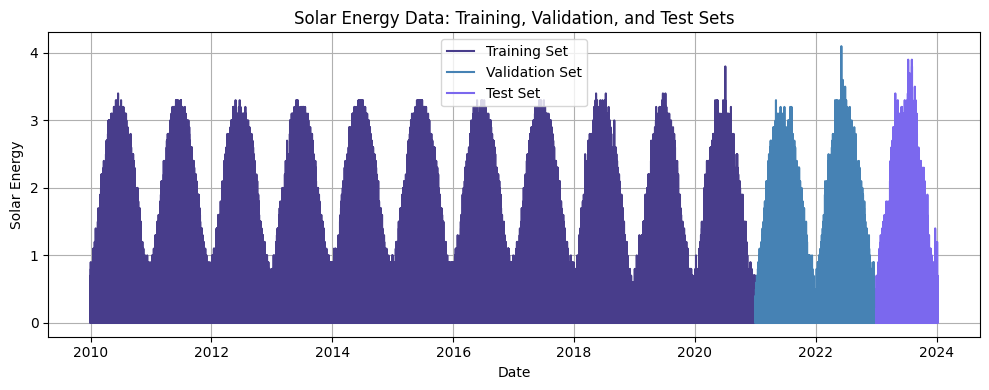

In [ ]:
# Plotting the separation of data with less vibrant colors
plt.figure(figsize=(10, 4))

# Plotting the training set
plt.plot(train_set.index, train_set['solarenergy'], label='Training Set', color='darkslateblue')
plt.plot(val_set.index, val_set['solarenergy'], label='Validation Set', color='steelblue')# Plotting the validation set
plt.plot(test_set.index, test_set['solarenergy'], label='Test Set', color='mediumslateblue')# Plotting the test set

# Adding labels and title
plt.title('Solar Energy Data: Training, Validation, and Test Sets')
plt.xlabel('Date')
plt.ylabel('Solar Energy')
plt.legend()  # Adding legend
plt.grid(True)  # Adding grid
plt.tight_layout()
plt.show()  # Displaying the plot
